# Sebelumnya data dalam bentuk JSON sudah diimport ke dalam MongoDB

- setting DB lokal 
        dbname = 'clothing_fit'
- nama collection -> rentCollection

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
    
import pymongo

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics



# SETTING
plt.style.use('ggplot')
#display maximum column and rows
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
red = '#ef4b4b'
black = '#584b42'
green = '#a0cc78'
yellow_ = '#f6d365'
blue_ = '#49beb7'


#METHODS

def connectMongoDB(dbname):
    client = pymongo.MongoClient('localhost', 27017)
    db = client[dbname]
    return db

dbname = 'clothing_fit'
db = connectMongoDB(dbname)

In [3]:
rent = list(db.rentCollection.find())
df_rent = pd.DataFrame(rent)
df_rent

# MENGECEK NULL
df_rent.isnull().sum()
# df_rent.info()

_id                     0
fit                     0
user_id                 0
bust size            1901
item_id                 0
weight               3161
rating                  3
rented for              0
review_text             0
body type            1510
review_summary          0
category                0
height                 76
size                    0
age                   103
review_date             0
sentiment_              0
height_cm               0
weight_kg            3161
age_                    0
review_date_            0
sentiment_summary       0
sentiment_text          0
dtype: int64

Ket  : data di atas menunjukkan ada beberapa nilai masih null

## Gambaran data yang terdapat di dalam collection.
- merupakan data transaksi yang memiliki
   - data customer, data item produk, data feedback transaksi

     customer
        user_id
        bust_size
        weight
        body type
        height
        age
    
     produk
        item_id
        rating
        category
        size

     transaksi
        fit
        rented for
        review_text
        review_summary
        review_date


In [4]:
df_rent.head()

,_id,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,sentiment_,height_cm,weight_kg,age_,review_date_,sentiment_summary,sentiment_text
0,5e2ab8ce9f84980caca61bf7,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016",positive,173.0,62.0,28.0,2016-04-20,positive,positive
1,5e2ab8ce9f84980caca61bf8,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013",positive,168.0,60.0,36.0,2013-06-18,positive,positive
2,5e2ab8ce9f84980caca61bf9,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015",positive,163.0,NaN,116.0,2015-12-14,positive,positive
3,5e2ab8ce9f84980caca61bfa,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014",positive,165.0,61.0,34.0,2014-02-12,positive,positive
4,5e2ab8ce9f84980caca61bfb,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016",positive,175.0,66.0,27.0,2016-09-26,positive,positive


# Meninjau kepuasan pelanggan berdasarkan review yang diberikan

In [5]:
# mendapatkan semua data review
review = df_rent[['review_date','review_text', 'review_summary']]
review

listReview = review['review_text']
listReviewSummary = review['review_summary']

## Menggunakan tools SentimentIntensityAnalyzer() untuk melihat insight dari feedback review yang diberikan

In [6]:
print("banyak review : ",len(listReview))
vader = SentimentIntensityAnalyzer()

# ========= get sentiment score
listSentimen = []
for i in listReview:
    sentimen = vader.polarity_scores(i)['compound']
    listSentimen.append(sentimen)

listSentimenSummary = []
for i in listReviewSummary:
    sentimen = vader.polarity_scores(i)['compound']
    listSentimenSummary.append(sentimen)

# ========== assign sentiment into DATAFRAME
review.loc[:,'sentiment_text'] = listSentimen
review.loc[:,'sentiment_summary'] = listSentimenSummary
review.loc[:,'sentiment_avg'] = (review['sentiment_text'] + review['sentiment_summary'] )/2

# ========== categorical sentiment rule berdasarkan dokumentasi vader NLTK
# netral = -0.05 hingga 0.05
# < -0.05 = negatif
# > 0.05 = positif
review.loc[:,'sentiment'] = review.loc[:,'sentiment_avg'].apply(lambda x : 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral' ))

review.loc[:,'sentiment_text_str'] = review.loc[:,'sentiment_text'].apply(lambda x : 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral' ))
review.loc[:,'sentiment_summary_str'] = review.loc[:,'sentiment_summary'].apply(lambda x : 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral' ))


review.head()

banyak review :  20027


c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,review_date,review_text,review_summary,sentiment_text,sentiment_summary,sentiment_avg,sentiment,sentiment_text_str,sentiment_summary_str
0,"April 20, 2016",An adorable romper! Belt and zipper were a lit...,So many compliments!,0.9453,0.5057,0.72550,positive,positive,positive
1,"June 18, 2013",I rented this dress for a photo shoot. The the...,I felt so glamourous!!!,0.8991,0.6333,0.76620,positive,positive,positive
2,"December 14, 2015",This hugged in all the right places! It was a ...,It was a great time to celebrate the (almost) ...,0.9333,0.8316,0.88245,positive,positive,positive
3,"February 12, 2014",I rented this for my company's black tie award...,Dress arrived on time and in perfect condition.,0.9559,0.5719,0.76390,positive,positive,positive
4,"September 26, 2016",I have always been petite in my upper body and...,Was in love with this dress !!!,0.6948,0.7249,0.70985,positive,positive,positive


Analisa sentimen diterapkan menggunakan vader sentiment analyser yang didapat dari NLTK

- Default rules vader:
      lebih dari 0.05 -> POSITIF
      kurang dari -0.05 -> NEGATIF

In [7]:
df_rent['sentiment_text'] = review.loc[:,'sentiment_text_str'] 
df_rent['sentiment_summary'] = review.loc[:,'sentiment_summary_str'] 
df_rent.head()

,_id,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,sentiment_,height_cm,weight_kg,age_,review_date_,sentiment_summary,sentiment_text
0,5e2ab8ce9f84980caca61bf7,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016",positive,173.0,62.0,28.0,2016-04-20,positive,positive
1,5e2ab8ce9f84980caca61bf8,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013",positive,168.0,60.0,36.0,2013-06-18,positive,positive
2,5e2ab8ce9f84980caca61bf9,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015",positive,163.0,NaN,116.0,2015-12-14,positive,positive
3,5e2ab8ce9f84980caca61bfa,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014",positive,165.0,61.0,34.0,2014-02-12,positive,positive
4,5e2ab8ce9f84980caca61bfb,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016",positive,175.0,66.0,27.0,2016-09-26,positive,positive


## Melihat bagaimana feedback review customer dari 2 macam feedback yang diberikan. Yaitu Review Detail dan Ringkasannya.

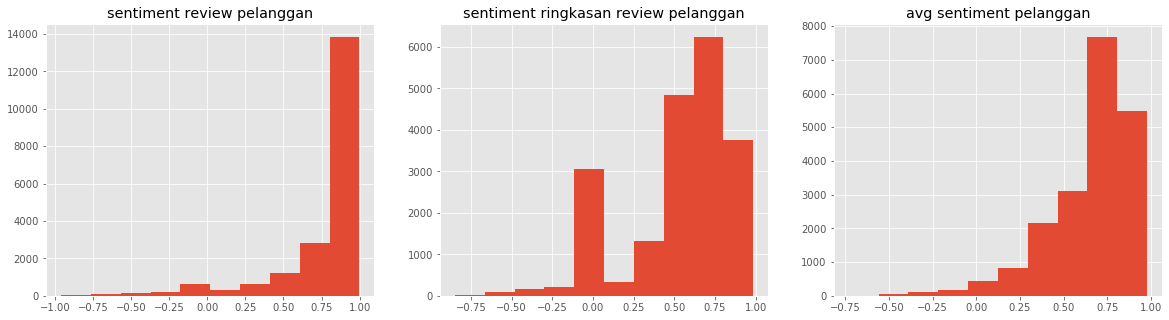

In [8]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title('sentiment review pelanggan')
plt.hist(review.sentiment_text)

plt.subplot(132)
plt.title('sentiment ringkasan review pelanggan')
plt.hist(review.sentiment_summary)

plt.subplot(133)
plt.title('avg sentiment pelanggan')
plt.hist(review.sentiment_avg)

plt.show()

#### Dari feedback customer ini dapat dilihat bahwa ada kenaikan angka netral pada feedback ringkas customer
<hr>

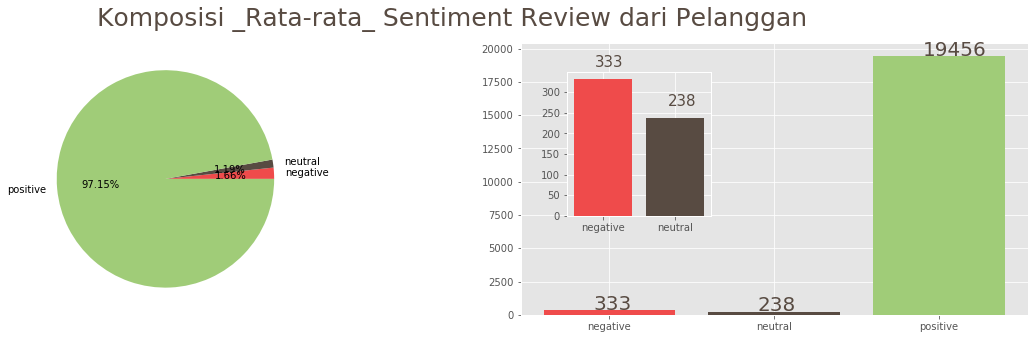

In [9]:
sums = review.sentiment.groupby(review.sentiment).count()
sums

fig = plt.figure(figsize=(20,5))
plt.suptitle('Komposisi Rata-rata Sentiment Review dari Pelanggan', fontsize='25', color=black)

plt.subplot(121)
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[red,black,green] )

plt.subplot(122)
index = sums.index
count = sums.tolist()

plt.bar(index[:],count[:], color=[red,black,green])
for i, v in enumerate(count[:]):
    plt.text(i - 0.1,v + 30 , str(v), color=black, fontsize='20')

# ZOOM IN perbandingan sentiment negatif dan netral
ax = fig.add_axes([0.58,0.4,0.1,0.4])
plt.bar(index[:2],count[:2], color=[red,black,])
for i, v in enumerate(count[:2]):
    plt.text(i - 0.1,v + 30 , str(v), color=black, fontsize='15')
plt.show()
# sums

Insight :

# __97% pelanggan__ puas terhadap pakaian yang disewa

namun masih ada __333 transaksi produk__ yang direview __NEGATIF__

<hr>

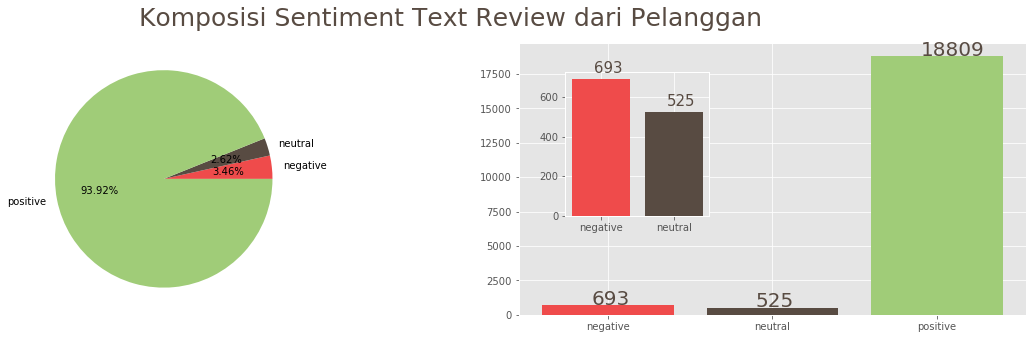

In [10]:
sums = df_rent.sentiment_text.groupby(df_rent.sentiment_text).count()
sums

fig = plt.figure(figsize=(20,5))
plt.suptitle('Komposisi Sentiment Text Review dari Pelanggan', fontsize='25', color=black)

plt.subplot(121)
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[red,black,green] )

plt.subplot(122)
index = sums.index
count = sums.tolist()

plt.bar(index[:],count[:], color=[red,black,green])
for i, v in enumerate(count[:]):
    plt.text(i - 0.1,v + 30 , str(v), color=black, fontsize='20')

# ZOOM IN perbandingan sentiment negatif dan netral
ax = fig.add_axes([0.58,0.4,0.1,0.4])
plt.bar(index[:2],count[:2], color=[red,black,])
for i, v in enumerate(count[:2]):
    plt.text(i - 0.1,v + 30 , str(v), color=black, fontsize='15')
plt.show()


Insight :

# __94% pelanggan__ memberikan review positif terhadap pakaian yang disewa

namun masih ada __693 transaksi produk__ yang direview __NEGATIF__

<hr>

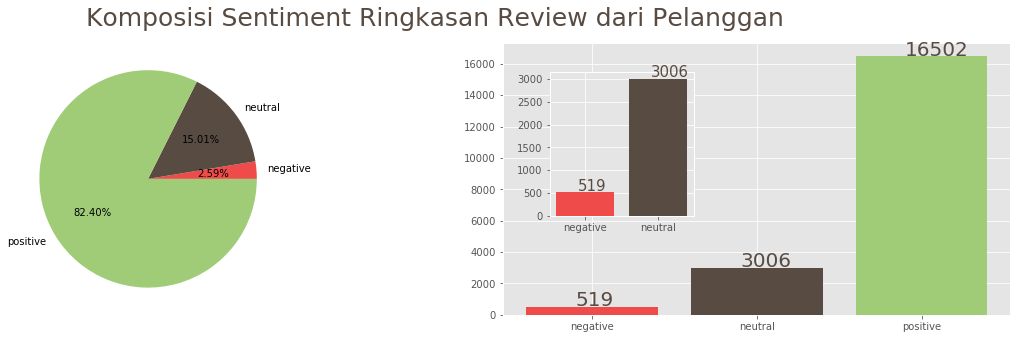

In [11]:
sums = df_rent.sentiment_summary.groupby(df_rent.sentiment_summary).count()
sums

fig = plt.figure(figsize=(20,5))
plt.suptitle('Komposisi Sentiment Ringkasan Review dari Pelanggan', fontsize='25', color=black)

plt.subplot(121)
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[red,black,green] )

plt.subplot(122)
index = sums.index
count = sums.tolist()

plt.bar(index[:],count[:], color=[red,black,green])
for i, v in enumerate(count[:]):
    plt.text(i - 0.1,v + 30 , str(v), color=black, fontsize='20')

# ZOOM IN perbandingan sentiment negatif dan netral
ax = fig.add_axes([0.58,0.4,0.1,0.4])
plt.bar(index[:2],count[:2], color=[red,black,])
for i, v in enumerate(count[:2]):
    plt.text(i - 0.1,v + 30 , str(v), color=black, fontsize='15')
plt.show()


Insight :

# __82.4% pelanggan__ memberikan ringkasan review positif terhadap pakaian yang disewa

#### namun masih ada __519 transaksi produk__ yang direview __NEGATIF__, dan 


## __3006 transaksi__ pelanggan memberi feedback yang __netral__


<hr>

<hr>

# UPDATE DATA + SENTIMEN => di mongoDB

In [15]:
df_rent.head()

,_id,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,sentiment_,height_cm,weight_kg,age_,review_date_,sentiment_summary,sentiment_text
0,5e2ab8ce9f84980caca61bf7,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016",positive,173.0,62.0,28.0,2016-04-20,positive,positive
1,5e2ab8ce9f84980caca61bf8,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013",positive,168.0,60.0,36.0,2013-06-18,positive,positive
2,5e2ab8ce9f84980caca61bf9,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015",positive,163.0,NaN,116.0,2015-12-14,positive,positive
3,5e2ab8ce9f84980caca61bfa,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014",positive,165.0,61.0,34.0,2014-02-12,positive,positive
4,5e2ab8ce9f84980caca61bfb,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016",positive,175.0,66.0,27.0,2016-09-26,positive,positive


In [16]:
dict_rent_transpose =df_rent.transpose().to_dict()

In [17]:
# UPDATE DATA DITAMBAH DENGAN DATA SENTIMENT DARI REVIEW

for i in range(len(df_rent)):
    old = rent[i]
    new = {"$set": dict_rent_transpose[i]}
    db.rentCollection.update_one(old, new)

In [18]:
# mengecek hasil update

rent = list(db.rentCollection.find())
df = pd.DataFrame(rent)
df.head()

,_id,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,sentiment_,height_cm,weight_kg,age_,review_date_,sentiment_summary,sentiment_text
0,5e2ab8ce9f84980caca61bf7,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016",positive,173.0,62.0,28.0,2016-04-20,positive,positive
1,5e2ab8ce9f84980caca61bf8,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013",positive,168.0,60.0,36.0,2013-06-18,positive,positive
2,5e2ab8ce9f84980caca61bf9,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015",positive,163.0,NaN,116.0,2015-12-14,positive,positive
3,5e2ab8ce9f84980caca61bfa,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014",positive,165.0,61.0,34.0,2014-02-12,positive,positive
4,5e2ab8ce9f84980caca61bfb,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016",positive,175.0,66.0,27.0,2016-09-26,positive,positive


<hr>
done